# Preprocess large PBMC panel

In [74]:
import scanpy as sc
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import datetime
import pytometry as pm


sc.logging.print_versions()
sc.settings.verbosity = 3 

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
asciitree           NA
asttokens           NA
backcall            0.2.0
brotli              NA
cachetools          5.2.0
certifi             2022.06.15
cffi                1.15.1
charset_normalizer  2.1.0
click               8.1.3
cloudpickle         2.0.0
colorama            0.4.5
cuda                11.7.0
cudf                22.02.00
cugraph             22.02.00+0.gf391a5c3.dirty
cupy                9.6.0
cupy_backends       NA
cupyx               NA
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2022.01.0
dask_cuda           0+unknown
dask_cudf           22.02.00
datashader          0.14.2
datashape           0.5.2
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
distributed         2021.10.0
entrypoints         0.4
executing           0.9.1
fasteners           0.17.3
fastrlock           0.8
flowio        

Add date.

In [75]:
now = datetime.datetime.now()
today = now.strftime("%Y%m%d")

In [76]:
#Define a nice colour map for gene expression
colors2 = plt.cm.Reds(np.linspace(0, 1, 80))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,35))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

# Introduction

In this notebook, we pre-process flow data of healthy human donors of the Knoll et al. (2023) study conducted at the DZNE Bonn (Germany) by the Anna Aschenbrenner group. 
We employ the following steps:
1. Load and convert fcs file into anndata format
2. Compensate for channel bleedthrough
3. Bi-exponential normalisation
4. Compute knn-graph
5. Compute louvain clustering

In [77]:
import os
import re

In [78]:
data_path = './../data/Convex_gating_test_MB/'

# Read files

Fetch all `fcs` files.

In [79]:
files_all = os.listdir(data_path)

In [80]:
files = [fileID for fileID in files_all if fileID.endswith('.fcs')]

In [82]:
adatas = []
for fileID in files[5:]: 
    print(fileID)
    meta_info = fileID.split('.fcs')[0].split('_')[-1]
        
    adata = pm.io.read_fcs(data_path  + fileID)
    adata.obs['sample'] = meta_info

    #run compensation
    pm.pp.compensate(adata)
    
    #move Time, FSC, SSC to obs
    pm.pp.split_signal(adata, var_key='channel')
    
    adatas.append(adata)

190411_HFGP2000 pilot_NL03.fcs
190411_HFGP2000 pilot_NL01.fcs
190411_HFGP2000 pilot_NL05.fcs
190411_HFGP2000 pilot_NL07.fcs
190411_HFGP2000 pilot_NL09.fcs


Concatenate data and save to file.

In [83]:
adata_all = ann.AnnData.concatenate(*adatas, join = 'outer', uns_merge = 'unique')

/home/buettnerm/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [84]:
adata_all

AnnData object with n_obs × n_vars = 1444540 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

In [85]:
adata_all.write(data_path + 'anndata/' + 'HIV_data_concatenated.h5ad')

# Pre-process data 

In [15]:
adata_all = sc.read(data_path + 'anndata/' + 'HIV_data_concatenated.h5ad')

## filter FSC and SSC

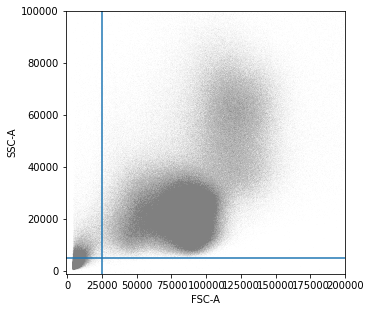

In [87]:
ax = sc.pl.scatter(adata_all, x='FSC-A', y='SSC-A', #color='gate_PBMC', 
                   show=False)
ax.set_ylim([-1e3, 1e5])
ax.set_xlim([-1e3, 2e5])
plt.vlines(x = 25000, ymin = -1e3, ymax=1e5)
plt.hlines(y = 5000, xmin = -1e3, xmax= 2e5)
plt.show()

Set FSC cutoff at 10.000 and SSC cutoff at 5000.

In [88]:
adata_all = adata_all[adata_all.obs['FSC-A']>25000]
adata_all = adata_all[adata_all.obs['SSC-A']>5000]

In [89]:
adata_all

View of AnnData object with n_obs × n_vars = 1324049 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch'
    var: 'channel', 'marker', 'signal_type'
    uns: 'meta'
    layers: 'original'

## filter doublets

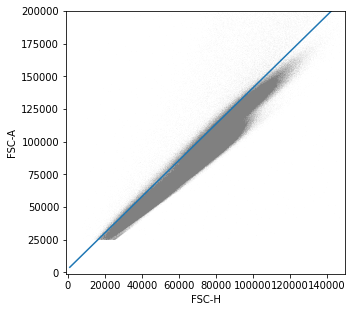

In [90]:
ax = sc.pl.scatter(adata_all, x='FSC-H', y='FSC-A', #color='sample', 
                   show=False)

ax.set_xlim([-1e3, 1.5e5])
ax.set_ylim([-1e3, 2e5])
plt.plot( [1e3, 1.47e6], [4e3, 2.04e6],linestyle = '-')
plt.show()

Filter out everything above the blue line.

In [91]:
y1 = 4e3
y2 = 1.47e6
x1 = 4e3 
x2 = 2.04e6
a = (y2-y1)/(x2-x1)
b = y1 - a*x1

In [92]:
above_line = (a * adata_all.obs['FSC-A'] + b - adata_all.obs['FSC-H']) <= 0 

In [93]:
np.sum(above_line)

1142610

In [94]:
adata_all = adata_all[above_line]

## Normalize data

Save compensated data to file.

In [95]:
adata_all.layers['compensated'] = adata_all.X

Load parameters for biexponential normalization from file. 

In [96]:
files_params = [fileID for fileID in files_all if fileID.count('_params_')>0]

In [98]:
meta_info = adata_all.obs['sample'].cat.categories.values

Read params from FlowJo file and match names.

In [99]:
adatas = []
for metaID in meta_info:
    fileID = [file for file in files_params if file.count(metaID)][0]
    params = pd.read_csv(data_path + fileID, 
                     index_col = 0)
    rename_col = [idx.split('parameters.')[-1] for idx in params.columns.values]
    params.columns = rename_col
    #use only area params
    params = params.loc[[channel.endswith('-A') for channel in params.index]]
    #rename index using the adata.var['channel'] info
    tmp_var = adata_all.var
    adata_all.var['channel_tmp'] = [channel.replace('/', '_') for channel in tmp_var.channel]
    channel_renames = dict(zip(tmp_var['channel_tmp'].values, 
                           tmp_var['marker'].values))
    params.index = params.index.map(channel_renames)
    #match channels
    tmp_var = pd.merge(tmp_var, params, left_index=True, right_index=True)
    
    #run normalization per sample
    adata_tmp = pm.tl.normalize_biExp(adata = adata_all[adata_all.obs['sample']==metaID].copy(), 
                                      negative = tmp_var['neg'], 
                                      positive = tmp_var['pos'], 
                                      width = tmp_var['widthBasis'],
                                      max_value = tmp_var['maxValue'],
                                      inplace=False
                                     )
    adatas.append(adata_tmp)

Concatenate data.

In [100]:
adata_filt = ann.AnnData.concatenate(*adatas, join = 'outer', uns_merge = 'unique')

In [101]:
adata_filt

AnnData object with n_obs × n_vars = 1142610 × 27
    obs: 'sample', 'FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'batch'
    var: 'channel', 'marker', 'signal_type', 'channel_tmp'
    uns: 'meta'
    layers: 'original', 'compensated'

Use first concatenation index.

In [102]:
adata_filt.obs_names = adata_all.obs_names

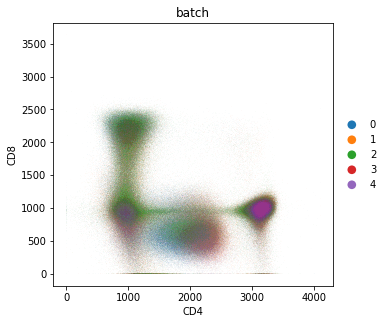

In [103]:
rcParams['figure.figsize']=(5,5)
sc.pl.scatter(adata_filt, x='CD4', y='CD8', color='batch')

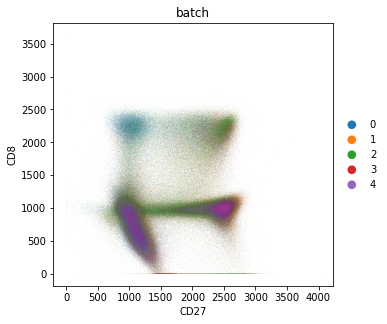

In [104]:
rcParams['figure.figsize']=(5,5)
sc.pl.scatter(adata_filt, x='CD27', y='CD8', color='batch')

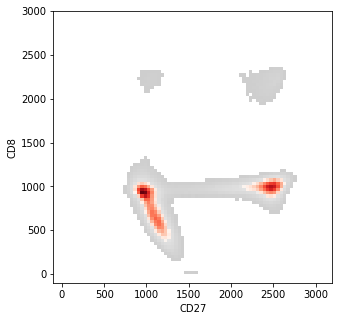

In [105]:
x= adata_filt.var_names=='CD27'
y = adata_filt.var_names=='CD8'

ax = plt.hist2d(adata_filt.X[:, x].flatten(), 
          adata_filt.X[:, y].flatten(), bins=100,
              cmin=300, cmap=mymap
              )
plt.xlabel('CD27')
plt.ylabel('CD8')
plt.ylim([-100, 3000])
plt.xlim([-100, 3200])
plt.show()

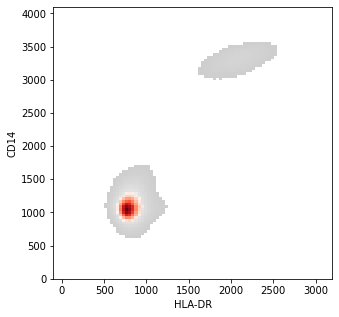

In [106]:
x= adata_filt.var_names=='HLA-DR'
y = adata_filt.var_names=='CD14'

ax = plt.hist2d(adata_filt.X[:, x].flatten(), 
          adata_filt.X[:, y].flatten(), bins=100,
              cmin=300, cmap=mymap
              )
plt.xlabel('HLA-DR')
plt.ylabel('CD14')
#plt.ylim([-100, 3000])
plt.xlim([-100, 3200])
plt.show()

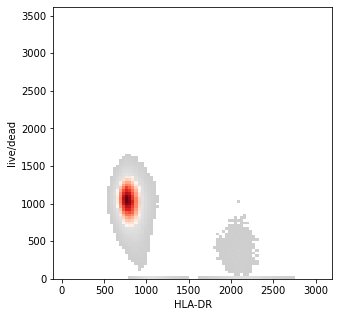

In [107]:
x= adata_filt.var_names=='HLA-DR'
y = adata_filt.var_names=='live/dead'

ax = plt.hist2d(adata_filt.X[:, x].flatten(), 
          adata_filt.X[:, y].flatten(), bins=100,
              cmin=300, cmap=mymap
              )
plt.xlabel('HLA-DR')
plt.ylabel('live/dead')
#plt.ylim([-100, 3000])
plt.xlim([-100, 3200])
plt.show()

## Compute embedding

In [108]:
#compute knn-graph and clustering
sc.pp.pca(adata_filt)
sc.pp.neighbors(adata_filt, n_neighbors = 15)
sc.tl.louvain(adata_filt, resolution = 0.5, flavor='rapids')

computing PCA
    with n_comps=26
    finished (0:00:02)
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:42)
running Louvain clustering
    using the "louvain" package of rapids
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


In [ ]:
sc.tl.umap(adata_filt)

computing UMAP


In [ ]:
adata_filt.write(data_path + 'anndata/' + 'HIV_data_norm.h5ad')

End of the notebook.